In [2]:
from apportionment import Apportionment
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
# Simulation parameters
voters = 1000
num_seats = 150
nit = 100
group_size = 100
link='NRSR2023_clean.csv'
file='test2024_dummy.csv'

ap = Apportionment(num_seats, voters, link=link) 
# -> TODO higher tresholds for coalitions
print("No of votes from source:", sum(ap.subject_votes.values()))
print("Considered votes:", ap.voters)
print("No. of seats:", num_seats)
weights = ap.subject_votes
# print(weights)

#apportionment test
result = ap.divide_seats("slovak")
if not (sum(result.values()) == 150): print(result.values()) 
else: print("seats ok")
if not (list(result.values()) == [32, 16, 11, 10, 42, 27, 12]): print(result.values()) 
else: print("apport ok")
print("Apportionment should work correctly.")

print("sum of probs:", sum(ap.probabilities.values()))
if not os.path.exists(file):
    ap.iterated_simulate('boxes', file, nit=nit, group_size=group_size)
else:
    print("Simulation did not happen, file already exists!")

link NRSR2023_clean.csv
No of votes from source: 4388872
Considered votes: 1000
No. of seats: 150
seats ok
apport ok
Apportionment should work correctly.
sum of probs: 0.9999999999999998
Simulation did not happen, file already exists!


In [4]:
def raw2visualisable(input_file, n_voters):

    # n_samples = int(n_voters * 0.003)

    # chunksize = 26 * n_samples * 10000

    chunksize = 130000000

    all_xdfs = []

    for chunk in pd.read_csv(input_file, chunksize=chunksize):
        chunk['weight'] = chunk['party_number'].map(weights)
        xdf = chunk.groupby('samples').apply(lambda x: np.average(x['diff'], weights=x['weight'])).reset_index(name='diff')
        all_xdfs.append(xdf)

    result_df = pd.concat(all_xdfs, axis=0, ignore_index=True)
    export_df = result_df.groupby('samples').apply(lambda x: np.average(x['diff'])).reset_index(name='diff')
    export_df.to_csv("vis-" + input_file, index=False)

    print(f"{input_file} done")


#teraz toto funguje velmi pekne lebo to spracuvam po viac riadkoch  co berie spolu po 50000 zaznamoch pre kazdu stranu. cele to treba este prisposobit tak aby to bralo v zavislosti od poctu volicov aby som mal skutocne logaritmicku pamatovu zlozitost...

In [5]:
raw2visualisable("100k-large.csv", 100000)
raw2visualisable("250k-large.csv", 250000)
raw2visualisable("500k-large.csv", 500000)
raw2visualisable("1m-large.csv", 1000000)
raw2visualisable("2m-large.csv", 2000000)
raw2visualisable("4_5m-large.csv", 4500000)

100k-large.csv done
250k-large.csv done
500k-large.csv done
1m-large.csv done
2m-large.csv done
4_5m-large.csv done


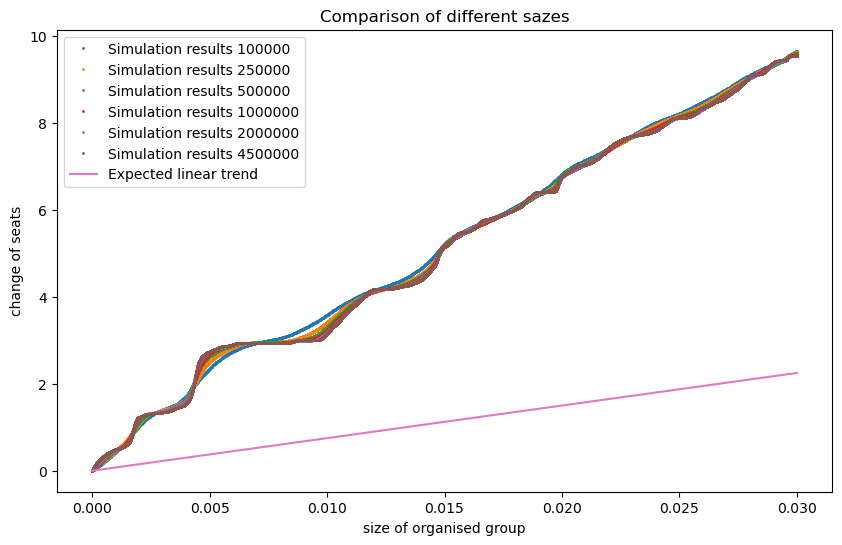

In [23]:
# PLOT

plt.figure(figsize=(10, 6))

names = ["100k-large.csv", "250k-large.csv", "500k-large.csv", "1m-large.csv", "2m-large.csv", "4_5m-large.csv"]
sizes = [100000, 250000, 500000, 1000000, 2000000, 4500000]

for name, size in zip(names, sizes):

    df = pd.read_csv("vis-"+name)

    x_values = df['samples'] / size
    y_values = df['diff']


    plt.plot(x_values, y_values, 'o', markersize=1, label=f'Simulation results {size}')


#fix expected trend
x = np.arange(0, 4)
y = (3 / 4) * x

plt.plot(x / 100, y, label='Expected linear trend')
plt.xlabel('size of organised group')
plt.ylabel('change of seats')
plt.title('Comparison of different sazes')

plt.legend()
plt.show()